In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import os
import random
import sklearn
from random import randrange
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class KNearstNeighbour:
  def __init__(self,k):
    self.k = k

  def train(self,X_train,y_train):
    self.X_train = X_train
    self.y_train = y_train
 
  def predict(self,X_test):
    distances = self.euclidean_distance(X_test)
    return self.predict_labels(distances)
  
  def euclidean_distance(self,X_test):
    #We want to compute distance 
    #for each test points we want to compute the distance with all other train points
    n_test = X_test.shape[0]
    n_train = self.X_train.shape[0]
    distances = np.zeros((n_test,n_train))

    for i in range(n_test):
      for j in range(n_train):
        distances[i,j] = np.sqrt(np.sum((X_test[i, :] - self.X_train[j, :]) ** 2) )
         
    return distances
  
  def predict_labels(self,distances):
      n_test = distances.shape[0]
      y_pred = np.zeros(n_test)
      for i in range(n_test):
        idx = np.argsort(distances[i,:])
        kn = self.y_train[idx[:self.k]]
        kn = kn.flatten()
        y_pred[i] = np.argmax(np.bincount(kn)).astype(int)
      return y_pred.reshape(len(y_test),1)

In [ ]:
def construct_DataMatrix_Noface(flag,n_noface):
  #flag == 0 reading faces image
  #flag == 1 then reading no face images
  if flag == 0:
    DIR = 'drive/MyDrive/Dataset/'
    D = []
    y = []
    for i in range(1,41):
      path = os.path.join(DIR,'s'+str(i))
      for j in range(1,11):
        img_path = os.path.join(path,str(j)+".pgm")
        #print(img_path)
        y.append(1)
        arr = cv2.imread(img_path,0)
        arr = arr.flatten().reshape(10304)
        D.append(arr) 
  
    D = np.array(D)
    y = np.array(y).reshape(400,1)
    return D,y
  else:  
    DIR = 'drive/MyDrive/Siberian-Husky'
    D = []
    y = []
    for i in range(1,n_noface):
      path = os.path.join(DIR,str(i)+'.pgm')
     # print(path)
      y.append(0)
      arr = cv2.imread(path,0)
      arr = cv2.resize(arr, (92, 112)) 
      arr = arr.flatten().reshape(10304)
      D.append(arr) 
  
    D = np.array(D)
    y = np.array(y).reshape(D.shape[0],1)
    return D,y

In [ ]:
def train_test_split(D,y,split):
  X_train = []
  y_train = []

  train_size = split*len(D)
  X_test = list(D)
  y_test = list(y)
  #print(len(y_test))

  while len(X_train) < train_size:
    index = randrange(len(X_test))
    #print(index)
    X_train.append(X_test.pop(index))
    y_train.append(y_test.pop(index))

  # print(len(y_test))
  # print(y_train)
  return np.array(X_train),np.array(X_test),np.array(y_train),np.array(y_test)

In [ ]:
D_face,y_face = construct_DataMatrix()
D_noface,y_noface = construct_DataMatrix_Noface(1,401)
D = np.concatenate((D_face, D_noface), axis=0)
y = np.concatenate((y_face, y_noface), axis=0)

NameError: ignored

In [ ]:
X_train, X_test ,y_train, y_test= train_test_split(D,y,0.5)


NameError: ignored

In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_test)
y_test = np.array(y_test)

print(X_train)
print(y_train.shape)

[[ 56  58  50 ...  63  75 189]
 [219 216 214 ... 161 169 142]
 [109 107 108 ...  66  67  67]]
(796, 1)


In [ ]:
class PCA:
  def __init__(self,X_train,X_test):
    self.X_train = X_train
    self.X_test = X_test
    self.Z_train = None
    self.Z_test = None
    self.value = None
    self.vector = None
    
  def fit(self):
    mu_train = np.mean(self.X_train,axis=0)
    mu_test = np.mean(self.X_test,axis = 0)

    self.Z_train = self.X_train - mu_train.T
    self.Z_test = self.X_test - mu_test.T


    cov = np.cov(self.Z_train.T,bias=True)
    #print(cov.shape)
    self.value, self.vector = np.linalg.eigh(cov)
    idx = self.value.argsort()[::-1]   
    self.value = self.value[idx]
    self.vector = self.vector[:,idx]
    return self.value,self.vector
  
  def findNumberOfComponents(self,alpha):
   #vector represents eigen vector
   #value represents eigen values
   #Alpha represents the desired explained variance / information
   #the function returns number of components/axis to achieve the given alpha
    variance_explained = np.array(((self.value/np.sum(self.value))))
    n_components = 0
    for i in range(len(variance_explained)):
      if alpha <= 0:
        break
      else:
        alpha -= variance_explained[i]
        n_components = n_components +1

    return n_components

  def transform(self,n_components):
    W = self.vector[:,0:n_components]  
    pca_train = np.dot(W.transpose() , self.Z_train.transpose()).transpose()  
    pca_test = np.dot(W.transpose() , self.Z_test.transpose()).transpose()
      
    return pca_train,pca_test


In [ ]:
class LDA:
  def __init__(self,X_train,X_test,y_train,y):
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y = y
    self.value = None
    self.vector = None

  def fit(self):
    classes = np.unique(y).reshape(2,)
    self.y_train = self.y_train.reshape(y_train.shape[0],)
    mu_sample = np.mean(self.X_train,axis=0)

    n_features = self.X_train.shape[1]
    B = np.zeros((n_features,n_features))
    S = np.zeros((n_features,n_features))


    for c in classes:
      X_class = self.X_train[c==self.y_train]
      mu_class = np.mean(X_class,axis = 0)
      n = X_class.shape[0]
      #print(n)
     #B = (mu_class - mu_sample) . (mu_class - mu_sample).T
      B += n*np.dot((mu_class - mu_sample),(mu_class - mu_sample).T)
     #S Or W = (X - mu_class).T . (X-mu_class)
      #S += np.dot((X_class - mu_class).T,(X_class - mu_class))
      S += np.cov((X_class - mu_class).T,bias = False) 
      
    Sinv = np.linalg.inv(S)
    SinvB = np.dot(Sinv,B)

    self.value, self.vector = np.linalg.eigh(SinvB)
    idx = self.value.argsort()[::-1]   
    self.value = self.value[idx]
    self.vector = self.vector[:,idx]
    
    return self.value,self.vector

  def transform(self,n_components):
    W = self.vector[:,:n_components]
    lda_train = np.dot(W.T,self.X_train.T).T
    lda_test = np.dot(W.T,self.X_test.T).T
   
    return lda_train,lda_test
    

In [ ]:
LDA_model = LDA(X_train,X_test,y_train,y)
value2,vector2,S,Sinv = LDA_model.fit()

NameError: ignored

In [ ]:
maxAccuracy = 0
n_components = 0
for i in range(30,70,2):
  lda_train,lda_test = LDA_model.transform(i)
  KNN = KNearstNeighbour(k=1)
  KNN.train(lda_train,y_train)
  y_pred = KNN.predict(lda_test) 
  arr = (np.sum(y_pred == y_test) / len(y_test))
  if arr > maxAccuracy:
    maxAccuracy = max(arr,maxAccuracy) 
    n_components = i
  print("Number Of Components = ",i,"And The Model Accuracy Is",arr)

print("The Maximum Accuracy Is",maxAccuracy ,"With Taking",n_components," Dominant EigenVector")

Number Of Components =  30 And The Model Accuracy Is 0.9640287769784173
Number Of Components =  32 And The Model Accuracy Is 0.9640287769784173
Number Of Components =  34 And The Model Accuracy Is 0.9640287769784173
Number Of Components =  36 And The Model Accuracy Is 0.9640287769784173
Number Of Components =  38 And The Model Accuracy Is 0.9640287769784173
Number Of Components =  40 And The Model Accuracy Is 0.9640287769784173
Number Of Components =  42 And The Model Accuracy Is 0.9616306954436451
Number Of Components =  44 And The Model Accuracy Is 0.9640287769784173
Number Of Components =  46 And The Model Accuracy Is 0.9616306954436451
Number Of Components =  48 And The Model Accuracy Is 0.9616306954436451
Number Of Components =  50 And The Model Accuracy Is 0.9664268585131894
Number Of Components =  52 And The Model Accuracy Is 0.9664268585131894
Number Of Components =  54 And The Model Accuracy Is 0.9664268585131894
Number Of Components =  56 And The Model Accuracy Is 0.961630695

In [ ]:
lda_train,lda_test = LDA_model.transform(n_components)
KNN = KNearstNeighbour(k=1)
KNN.train(lda_train,y_train)
y_pred = KNN.predict(lda_test) 
arr = (np.sum(y_pred == y_test) / len(y_test))
  
print("The Model Accuracy Is",arr)
accuracy = []
n_noface = []
accuracy.append(arr)
n_noface.append(192)

The Model Accuracy Is 0.6081081081081081


In [ ]:
#n_components = 44
dic={1:"Face",2:"No-Face"}
x = int(y_test[0])
print(x)
#print(dic[y_test[0]])

for i in range(len(y_pred)):
  if(y_pred[i] == y_test[i]):
    print("Correct Prediction")
    print("Expected Is" ,dic[int(y_test[i])],"Predicted Is", dic[int(y_pred[i])])
    print()
  else:
    print("Incorrect Prediction")
    print("Expected Is" ,dic[int(y_test[i])],"Predicted Is" ,dic[int(y_pred[i])])
    print()

1
Incorrect Prediction
Expected Is Face Predicted Is No-Face

Incorrect Prediction
Expected Is Face Predicted Is No-Face

Correct Prediction
Expected Is Face Predicted Is Face

Incorrect Prediction
Expected Is Face Predicted Is No-Face

Correct Prediction
Expected Is Face Predicted Is Face

Correct Prediction
Expected Is Face Predicted Is Face

Correct Prediction
Expected Is Face Predicted Is Face

Incorrect Prediction
Expected Is Face Predicted Is No-Face

Correct Prediction
Expected Is Face Predicted Is Face

Correct Prediction
Expected Is Face Predicted Is Face

Correct Prediction
Expected Is Face Predicted Is Face

Correct Prediction
Expected Is Face Predicted Is Face

Incorrect Prediction
Expected Is Face Predicted Is No-Face

Incorrect Prediction
Expected Is Face Predicted Is No-Face

Correct Prediction
Expected Is Face Predicted Is Face

Correct Prediction
Expected Is Face Predicted Is Face

Correct Prediction
Expected Is Face Predicted Is Face

Correct Prediction
Expected Is Fa

In [ ]:
#n_components = 44
dic={1:"Face",0:"No-Face"}

for i in range(len(y_pred)):
  if(y_pred[i] == y_test[i]):
    print("Correct Prediction")
    print("Expected Is" ,dic[int(y_test[i])],"Predicted Is", dic[int(y_pred[i])])
    print()
  else:
    print("Incorrect Prediction")
    print("Expected Is" ,dic[int(y_test[i])],"Predicted Is" ,dic[int(y_pred[i])])
    print()


Correct Prediction
Expected Is Face Predicted Is Face

Correct Prediction
Expected Is Face Predicted Is Face

Correct Prediction
Expected Is Face Predicted Is Face

Correct Prediction
Expected Is Face Predicted Is Face

Correct Prediction
Expected Is Face Predicted Is Face

Correct Prediction
Expected Is Face Predicted Is Face

Correct Prediction
Expected Is Face Predicted Is Face

Correct Prediction
Expected Is Face Predicted Is Face

Correct Prediction
Expected Is Face Predicted Is Face

Correct Prediction
Expected Is Face Predicted Is Face

Correct Prediction
Expected Is Face Predicted Is Face

Correct Prediction
Expected Is Face Predicted Is Face

Correct Prediction
Expected Is Face Predicted Is Face

Correct Prediction
Expected Is Face Predicted Is Face

Correct Prediction
Expected Is Face Predicted Is Face

Correct Prediction
Expected Is Face Predicted Is Face

Correct Prediction
Expected Is Face Predicted Is Face

Correct Prediction
Expected Is Face Predicted Is Face

Correct Pr

In [ ]:
print(y_pred[1])
print(y_test == )

[1.]
[1]


In [ ]:
total_accuracy = []
#number of n
n_total = []
n_nofaces = [201,301,401,435]
for n in n_nofaces:
  D_face,y_face = construct_DataMatrix_Noface(0,0)
  D_noface,y_noface = construct_DataMatrix_Noface(1,n)
  D = np.concatenate((D_face, D_noface), axis=0)
  y = np.concatenate((y_face, y_noface), axis=0)
  X_train, X_test, y_train, y_test = train_test_split(D,y,0.5)
  print("Number Of No-Face Images Is ",D_noface.shape[0])
  print("Total Number Of Records Is ",D.shape[0])

  LDA_model = LDA(X_train,X_test,y_train,y)
  value2,vector2 = LDA_model.fit()

  maxAccuracy = 0
  n_components = 0
  for i in range(30,50):
    lda_train,lda_test = LDA_model.transform(i)
    KNN = KNearstNeighbour(k=1)
    KNN.train(lda_train,y_train)
    y_pred = KNN.predict(lda_test) 
    arr = (np.sum(y_pred == y_test) / len(y_test))
    if arr > maxAccuracy:
      maxAccuracy = max(arr,maxAccuracy) 
      n_components = i
  print("The Maximum Accuracy Is",maxAccuracy ,"With Taking",n_components," Dominant EigenVector")
  total_accuracy.append(maxAccuracy)
  n_total.append(n)


600
Number Of No-Face Images Is  200
Total Number Of Records Is  600
The Maximum Accuracy Is 0.9333333333333333 With Taking 30  Dominant EigenVector
700
Number Of No-Face Images Is  300
Total Number Of Records Is  700
The Maximum Accuracy Is 0.9428571428571428 With Taking 30  Dominant EigenVector
800
Number Of No-Face Images Is  400
Total Number Of Records Is  800
The Maximum Accuracy Is 0.96 With Taking 30  Dominant EigenVector
834
Number Of No-Face Images Is  434
Total Number Of Records Is  834
The Maximum Accuracy Is 0.9592326139088729 With Taking 30  Dominant EigenVector


Text(0.5, 1.0, 'LDA')

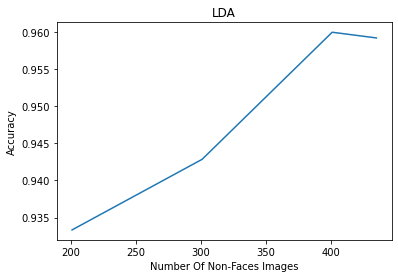

In [ ]:
#print(n_total)
plt.plot(n_total,total_accuracy)
#plt.plot(n_total,total_accuracy)
plt.ylabel("Accuracy")
plt.xlabel("Number Of Non-Faces Images")
plt.title("LDA")

In [ ]:
total_accuracy = []
#number of n
n_total = []
n_nofaces = [201,301,401,435]
for n in n_nofaces:
  D_face,y_face = construct_DataMatrix_Noface(0,0)
  D_noface,y_noface = construct_DataMatrix_Noface(1,n)
  D = np.concatenate((D_face, D_noface), axis=0)
  y = np.concatenate((y_face, y_noface), axis=0)
  X_train, X_test, y_train, y_test = train_test_split(D,y,0.5)
  print("Number Of No-Face Images Is ",D_noface.shape[0])
  print("Number Of Face Images Is  ",D_face.shape[0])

  pca_model = PCA(X_train,X_test)
  value,vector = pca_model.fit()  

  n_components =  pca_model.findNumberOfComponents(0.8)
  pca_train,pca_test = pca_model.transform(n_components)
  KNN = KNearstNeighbour(k=1)
  KNN.train(pca_train,y_train)
  y_pred = KNN.predict(pca_test) 
  arr = (np.sum(y_pred == y_test) / len(y_test))
  print("The Accuracy Is",arr ,"With Taking",n_components," Dominant EigenVector")
  total_accuracy.append(arr)
  n_total.append(n)

Number Of No-Face Images Is  200
Number Of Face Images Is   400
The Accuracy Is 0.9333333333333333 With Taking 45  Dominant EigenVector
Number Of No-Face Images Is  300
Number Of Face Images Is   400
The Accuracy Is 0.9457142857142857 With Taking 44  Dominant EigenVector
Number Of No-Face Images Is  400
Number Of Face Images Is   400
The Accuracy Is 0.9625 With Taking 45  Dominant EigenVector
Number Of No-Face Images Is  434
Number Of Face Images Is   400
The Accuracy Is 0.9448441247002398 With Taking 49  Dominant EigenVector


Text(0.5, 1.0, 'PCA')

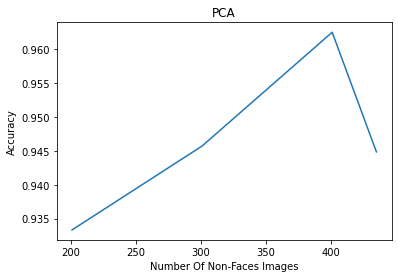

In [ ]:
plt.plot(n_total,total_accuracy)
plt.ylabel("Accuracy")
plt.xlabel("Number Of Non-Faces Images")
plt.title("PCA")

NameError: ignored

In [ ]:
D_face,y_face = construct_DataMatrix_Noface(0,0)
D_noface,y_noface = construct_DataMatrix_Noface(1,401)
D = np.concatenate((D_face, D_noface), axis=0)
y = np.concatenate((y_face, y_noface), axis=0)
X_train, X_test, y_train, y_test = train_test_split(D,y,0.5)
'''
print("Number Of No-Face Images Is ",D_noface.shape[0])
print("Total Number Of Records Is ",D.shape[0])

LDA_model = LDA(X_train,X_test,y_train,y)
value2,vector2 = LDA_model.fit()
lda_train,lda_test = LDA_model.transform(1)
KNN = KNearstNeighbour(k=1)
KNN.train(lda_train,y_train)
y_pred = KNN.predict(lda_test) 
arr = (np.sum(y_pred == y_test) / len(y_test))
print("The Maximum Accuracy Is",arr ,"With Taking",1," Dominant EigenVector")
'''

'\nprint("Number Of No-Face Images Is ",D_noface.shape[0])\nprint("Total Number Of Records Is ",D.shape[0])\n\nLDA_model = LDA(X_train,X_test,y_train,y)\nvalue2,vector2 = LDA_model.fit()\nlda_train,lda_test = LDA_model.transform(1)\nKNN = KNearstNeighbour(k=1)\nKNN.train(lda_train,y_train)\ny_pred = KNN.predict(lda_test) \narr = (np.sum(y_pred == y_test) / len(y_test))\nprint("The Maximum Accuracy Is",arr ,"With Taking",1," Dominant EigenVector")\n'

In [ ]:
class LDA:
  def __init__(self,X_train,X_test,y_train,y):
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y = y
    self.value = None
    self.vector = None
  def fit(self):
    classes = np.unique(y).reshape(2,)
    self.y_train = self.y_train.reshape(y_train.shape[0],)
    n_features = self.X_train.shape[1]
    B = np.zeros((n_features,n_features))
    S = np.zeros((n_features,n_features))
    X_class0 = self.X_train[0==self.y_train]
    mu_class0 = np.mean(X_class0,axis = 0).reshape(n_features,1)
    X_class1 = self.X_train[1==self.y_train]
    mu_class1 = np.mean(X_class1,axis =0).reshape(n_features,1)
    B = np.dot((mu_class0 - mu_class1),(mu_class0 - mu_class1).T)
    mu_class0 = mu_class0.reshape(n_features,)
    mu_class1 = mu_class1.reshape(n_features,)
    S_class0 = (X_class0 - mu_class0.T).T.dot(X_class0 - mu_class0.T)
    S_class1 = (X_class1 - mu_class1.T).T.dot(X_class1 - mu_class1.T)
    S = S_class0 + S_class1
    Sinv = np.linalg.inv(S)
    SinvB = np.dot(Sinv,B)
    self.value, self.vector = np.linalg.eigh(SinvB)
    idx = self.value.argsort()[::-1]   
    self.value = self.value[idx]
    self.vector = self.vector[:,idx]
    return self.value,self.vector
  def transform(self,n_components):
    W = self.vector[:,:n_components]
    lda_train = np.dot(W.T,self.X_train.T).T
    lda_test = np.dot(W.T,self.X_test.T).T
   
    return lda_train,lda_test
    

In [ ]:
total_accuracy = []
#number of n
n_total = []
n_nofaces = [201,301,401,435]
for n in n_nofaces:
  D_face,y_face = construct_DataMatrix_Noface(0,0)
  D_noface,y_noface = construct_DataMatrix_Noface(1,n)
  D = np.concatenate((D_face, D_noface), axis=0)
  y = np.concatenate((y_face, y_noface), axis=0)
  X_train, X_test, y_train, y_test = train_test_split(D,y,0.5)
  print("Number Of No-Face Images Is ",D_noface.shape[0])
  print("Total Number Of Records Is ",D.shape[0])

  LDA_model = LDA(X_train,X_test,y_train,y)
  value2,vector2 = LDA_model.fit()

  maxAccuracy = 0
  n_components = 0
  for i in range(30,50):
    lda_train,lda_test = LDA_model.transform(i)
    KNN = KNearstNeighbour(k=1)
    KNN.train(lda_train,y_train)
    y_pred = KNN.predict(lda_test) 
    arr = (np.sum(y_pred == y_test) / len(y_test))
    if arr > maxAccuracy:
      maxAccuracy = max(arr,maxAccuracy) 
      n_components = i
  print("The Maximum Accuracy Is",maxAccuracy ,"With Taking",n_components," Dominant EigenVector")
  total_accuracy.append(maxAccuracy)
  n_total.append(n)


KeyboardInterrupt: ignored

Text(0.5, 1.0, 'LDA')

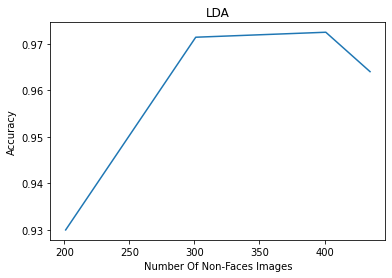

In [ ]:
plt.plot(n_total,total_accuracy)
plt.ylabel("Accuracy")
plt.xlabel("Number Of Non-Faces Images")
plt.title("LDA")

Confusion Matrix
 [[205  15]
 [  0 197]]
The Number Of Images Predicted Positive(Face) And It's True Prediction Is(True-Positive) 197
The Number Of Images Predicted Negative(Non-Face) And It's True Prediction Is(True-Negative) 205
The Number Of Images Predicted Negative(Non-Face) And It's False Prediction Is(False-Negative) 0
The Number Of Images Predicted Positive(Face) And It's False Prediction Is(False-Positive) 15


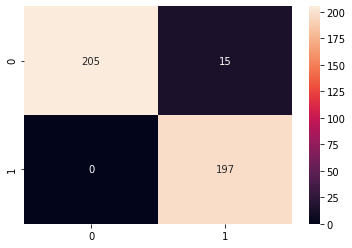

In [ ]:
from sklearn.metrics import confusion_matrix
x = np.array(confusion_matrix(y_test, y_pred))
print("Confusion Matrix\n",x)
print("The Number Of Images Predicted Positive(Face) And It's True Prediction Is(True-Positive)",x[1][1])
print("The Number Of Images Predicted Negative(Non-Face) And It's True Prediction Is(True-Negative)",x[0][0])
print("The Number Of Images Predicted Negative(Non-Face) And It's False Prediction Is(False-Negative)",x[1][0])
print("The Number Of Images Predicted Positive(Face) And It's False Prediction Is(False-Positive)",x[0][1])
sns.heatmap(x,annot=True, fmt='g')

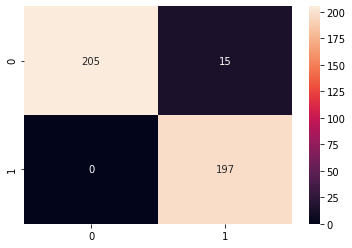

Text(0.5, 1.0, 'LDA')

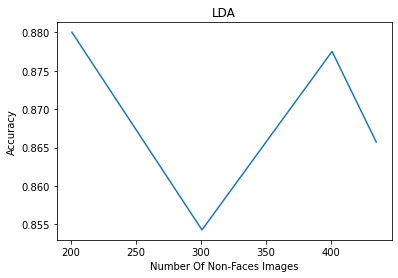

In [ ]:
plt.plot(n_total,total_accuracy)
plt.ylabel("Accuracy")
plt.xlabel("Number Of Non-Faces Images")
plt.title("LDA")

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[170,  23],
       [  1, 205]])

In [ ]:
D_face,y_face = construct_DataMatrix_Noface(0,0)
D_noface,y_noface = construct_DataMatrix_Noface(1,401)
D = np.concatenate((D_face, D_noface), axis=0)
y = np.concatenate((y_face, y_noface), axis=0)
X_train, X_test, y_train, y_test = train_test_split(D,y,0.5)
print("Number Of No-Face Images Is ",D_noface.shape[0])
print("Total Number Of Records Is ",D.shape[0])

LDA_model = LDA(X_train,X_test,y_train,y)
value2,vector2 = LDA_model.fit()

Number Of No-Face Images Is  400
Total Number Of Records Is  800


In [ ]:
def findNumberOfComponents(alpha):
   #vector represents eigen vector
   #value represents eigen values
   #Alpha represents the desired explained variance / information
   #the function returns number of components/axis to achieve the given alpha
    variance_explained = np.array(((value/np.sum(self.value))))
    n_components = 0
    for i in range(len(variance_explained)):
      if alpha <= 0:
        break
      else:
        alpha -= variance_explained[i]
        n_components = n_components +1

    return n_components

In [ ]:
print(findNumberOfComponents(0.8))

NameError: ignored